# **Thermal Sign Language Digits Imaging**

The dataset contains low resolution thermal images corresponding to various sign language digits represented by hand and captured using the Omron D6T thermal camera. The resolution of the camera is 32X32 pixels.

The task involves **classifying the images into 10 classes**: signs from 0 to 9.

The [Low resolution thermal imaging dataset of sign language digits](https://zenodo.org/record/6053169) is composed of thermal images of 9 fingers sign acquired with (MEMS) thermal sensor. Each image has a resolution 32X32 pixels. The dataset consists of 3200 images corresponding to ten sign digits, 0–9. Thus, each sign language digit consists of 320 images collected from different persons.

# **Download dataset:**

In [ ]:
import urllib.request
url = 'https://zenodo.org/record/6053169/files/thermal_image_dataset-20210815T145411Z-001.zip?download=1'
u = urllib.request.urlopen(url)
data = u.read()
u.close()
with open("./thermal_image_dataset.zip", "wb") as f :
   f.write(data)


In [ ]:
import zipfile

with zipfile.ZipFile("thermal_image_dataset.zip","r") as zip_ref:
    zip_ref.extractall(".")

Just for Mac users, remove the .DS_Store files:

In [ ]:
import os

for root, dirs, files in os.walk('./thermal_image_dataset/'):
    for file in files:
        if file.endswith('.DS_Store'):
            path = os.path.join(root, file)
            print("Deleting: %s" % (path))
            if os.remove(path):
                print("Unable to delete!")
            else:
                print("Deleted...")

In [ ]:
import sklearn.datasets

dataset = sklearn.datasets.load_files('./thermal_image_dataset', shuffle='False')

Check the number of samples (should be 3200):

In [ ]:
samples_number = len(dataset.data)
print("Number of samples: ", samples_number)

Number of samples:  3201


Pre-process files content in order to convert bytes images into array of RGB

In [ ]:
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
for index, data in enumerate(dataset.data) :
    image_bytesio = io.BytesIO(data)
    image = Image.open(image_bytesio)
    image_array = np.array(image)
    image_array=image_array[:, :, :3]
    dataset.data[index]=image_array

Show some sample as a RGB image:

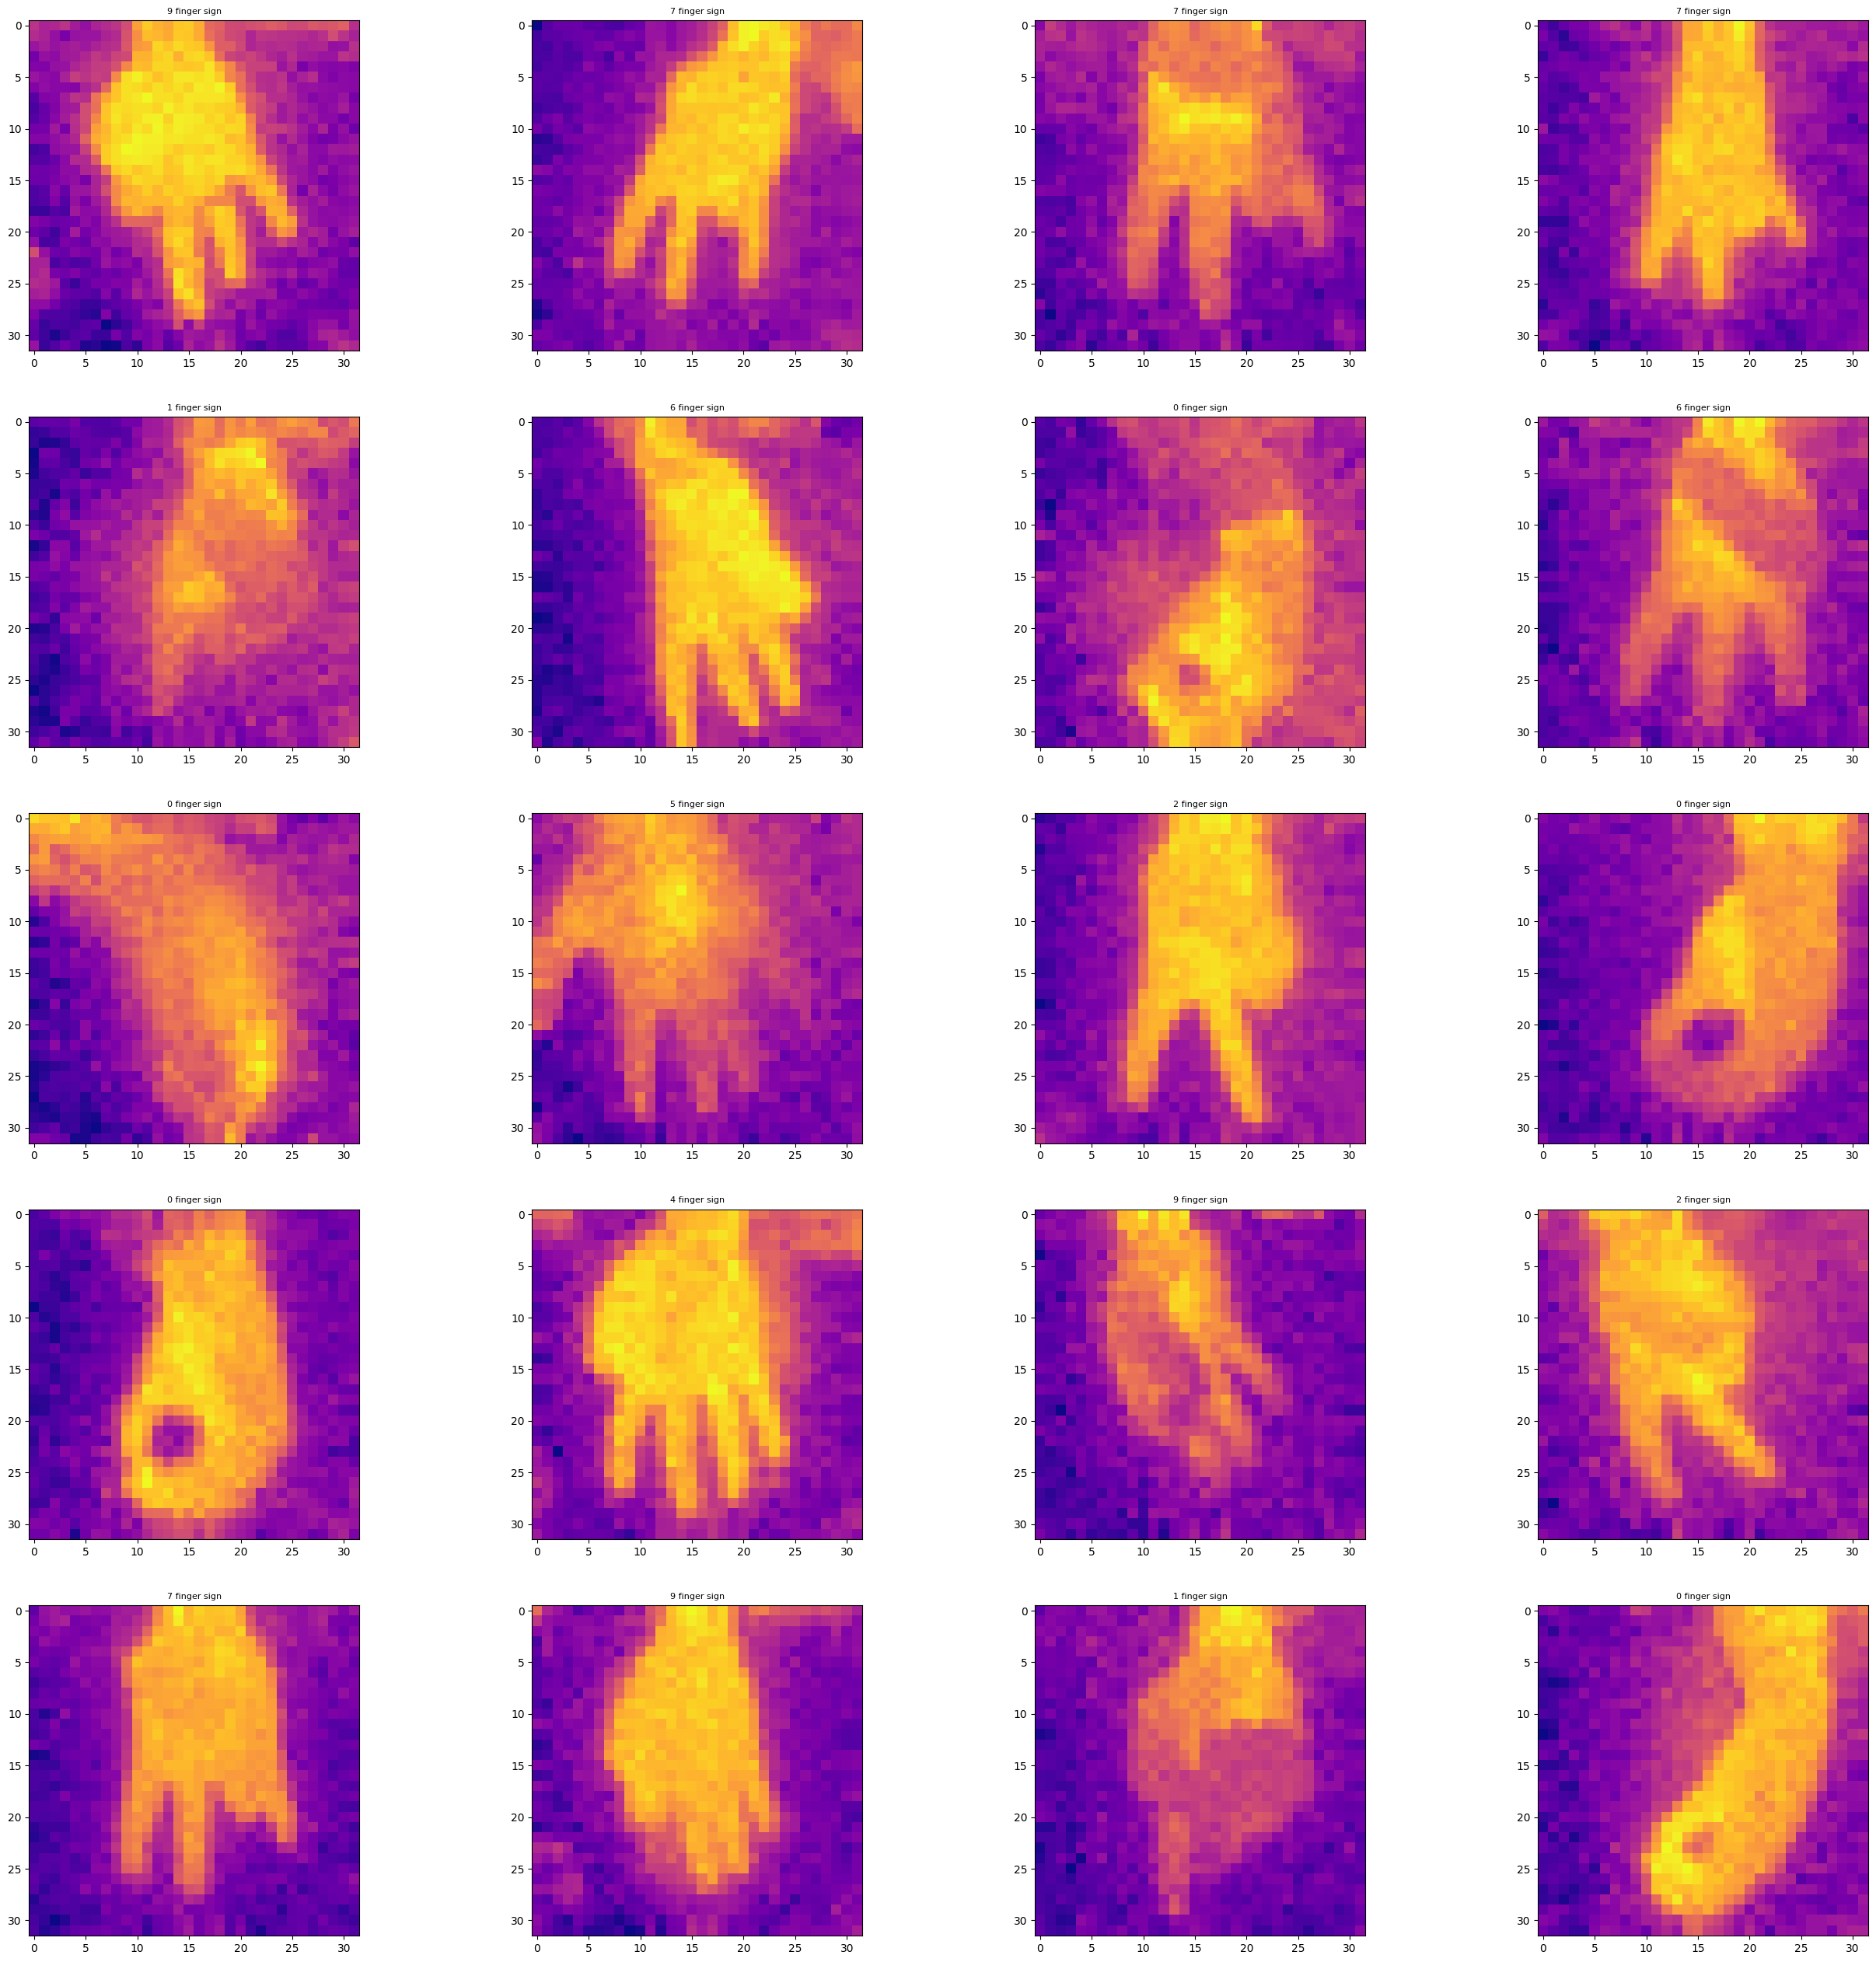

In [ ]:
import random

w = 32
h = 32
fig = plt.figure(figsize=(32, 32))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    index = random.randint(0, samples_number)
    img = dataset.data[index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(str(dataset.target[index])+ " finger sign", fontsize=8)
plt.show()

Prepare the dataset for training:

In [ ]:
X = np.array(dataset.data)/255
y = np.array(dataset.target)
print("Shape X: ", X.shape)
print("Shape y: ", y.shape)

In [ ]:
for i in range(10):
  print("Samples number"+str(i)+ " :", np.count_nonzero(y == i))

Get the **height**, **width** and **number of channels** of the images

In [ ]:
height , width , number_of_channels = X[0].shape

The  classes are balanced, so accuracy is a good metric to use
Preprocessing and Spliting the dataset:

In [ ]:
X = np.array(dataset.data)
y = np.array(dataset.target)

train_size=int(len(dataset.data) * 0.85)
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

val_size= int(len(dataset.data) * 0.15)
X_valid, X_train = X_train_full[:val_size], X_train_full[val_size:]
y_valid, y_train = y_train_full[:val_size], y_train_full[val_size:]


print('Shape:', X_train.shape)
print('Type:', X_train.dtype)

In [ ]:
linear_classifier_accuracy=[]
MLP_classifier_accuracy=[]
CNN_classifier_accuracy=[]
DCNN_classifier_accuracy=[]
NN_model_sizes=[]

# **NN models**
In this section we implement all general functions that can be used by all NN models

In [ ]:
pip install -q -U keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.2 MB/s eta 0:00:00


Import needed libraries

In [ ]:
!pip install scikit-optimize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import time
import tracemalloc
import sklearn
from keras.backend import binary_crossentropy
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization

In [ ]:
epochs=300
batch_size=32
def NN_hyperparameter_fit(hyperparameter,Type_model):
  if (Type_model=="CNN"):
    model=build_model(hyperparameter)
  if (Type_model=="DCNN"):
    model=build_model_DCC(hyperparameter)
  model.summary()
  history = model.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_valid, y_valid))
  plot_model_performance(history,epochs)
  return model,history


In [ ]:
def ML_hyperparameters_study(classifier, param_grid, X_train_ML, X_test_ML, y_train_full_ML, y_test_full_ML,random=False):
    classifier.random_state = 42
    grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=1)
    grid_search.fit(X_train_ML, y_train_full_ML)
    results = grid_search.cv_results_
    mean_training_score_all = []
    params_all = []
    testing_accuracy = []
    models_size = []
    execution_time_list = []
    total_allocated_memory=[]
    average_allocated_memory=[]
    precision_list, recall_list, f1_score_list=[],[],[]

    def fit_and_measure_memory(model, X_train_ML, y_train_full_ML):
      tracemalloc.start()
      start_time = time.time()
      model.fit(X_train_ML, y_train_full_ML)
      snapshot = tracemalloc.take_snapshot()
      tracemalloc.stop()
      end_time = time.time()
      execution_time_list.append(end_time - start_time)
      return snapshot

    for mean_score, params in zip(results['mean_test_score'], results['params']):
        mean_training_score_all.append(mean_score)
        params_all.append(params)
        hyper_model = classifier
        if random:
            hyper_model.random_state = 42
        hyper_model.set_params(**params)
        snap = fit_and_measure_memory(hyper_model, X_train_ML, y_train_full_ML)
        # Calculate the total allocated memory from the snapshot
        total_memory=sum(stat.size for stat in snap.statistics('lineno'))
        total_allocated_memory.append(format_memory(total_memory))
        # Calculate the average allocated memory
        num_snapshots = len(snap.statistics('lineno'))
        average_allocated_memory.append(format_memory(total_memory / num_snapshots))
        y_pred = hyper_model.predict(X_test_ML)
        testing_accuracy.append(accuracy_score(y_test_full_ML, y_pred))
        precision_value, recall_value, f1_score_value, support_value = sklearn.metrics.precision_recall_fscore_support(y_test_full_ML , y_pred, average= 'weighted' )
        precision_list.append(precision_value)
        recall_list.append(recall_value)
        f1_score_list.append(f1_score_value)
        models_size.append(format_memory(calculate_ML_size(hyper_model, "model(" + str(mean_score) + ")")))

    best_params = grid_search.best_params_
    return [params_all,testing_accuracy,precision_list,recall_list,f1_score_list, models_size, execution_time_list,total_allocated_memory,average_allocated_memory], best_params ,mean_training_score_all

In [ ]:
def evaluate_NN_models(model_list):
  loss, accuracy , y_pred ,precision, recall ,f1_score ,support ,confusion_matrix_list = [], [], [], [], [], [], [], []
  for model in model_list:
    loss_value,accuracy_value=model.evaluate(X_test, y_test)
    loss.append(loss_value)
    accuracy.append(accuracy_value)
    y_pred_value=np.argmax(model.predict(X_test), axis = 1)
    y_pred.append(y_pred_value)
    precision_value, recall_value, f1_score_value, support_value = sklearn.metrics.precision_recall_fscore_support(y_test , y_pred_value, average= 'weighted' )
    precision.append(precision_value)
    recall.append(recall_value)
    f1_score.append(f1_score_value)
    support.append(support_value)
    confusion_matrix_value=confusion_matrix(y_test, y_pred_value)
    confusion_matrix_list.append(confusion_matrix_value)
  return [accuracy ,precision, recall ,f1_score],confusion_matrix_list,y_pred


In [ ]:
def plot_model_performace_accuracy(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
  ax1.plot(history[0].history['accuracy'], 'g', label='Training Accuracy')
  ax1.plot(history[0].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax1.set_title('training and validation')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.set_ylim(0.1, 1.01)
  ax1.grid(True)
  ax1.legend()
  ax2.plot(history[1].history['accuracy'], 'g', label='Training Accuracy')
  ax2.plot(history[1].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax2.set_title('training and validation')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.set_ylim(0.1, 1.01)
  ax2.grid(True)
  ax2.legend()
  ax3.plot(history[2].history['accuracy'], 'g', label='Training Accuracy')
  ax3.plot(history[2].history['val_accuracy'], color='orange', label='Validation Accuracy')
  ax3.set_title('training and validation')
  ax3.set_xlabel('epoch')
  ax3.set_ylabel('accuracy')
  ax3.set_ylim(0.1, 1.01)
  plt.grid(True)
  plt.legend()
  plt.show()

In [ ]:
def plot_model_performance(history,number_of_epochs):
  print('CNN model training accuracy: ', history.history['accuracy'][number_of_epochs - 1])
  print('CNN model validation accuracy: ', history.history['val_accuracy'][number_of_epochs - 1])
  plt.figure()
  plt.plot(history.history['loss'], 'g', label='Training Loss')
  plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ax, conf_matrix, title, cmap):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax)
    ax.set_title(title)

def draw_confusion_matrix(matrix,name):
  colormap=["Blues","Greens","Oranges"]
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  for i in range(len(matrix)):
    plot_confusion_matrix(axes[i], matrix[i], "Confusion Matrix  "+name+ str(i+1), colormap[i])
  plt.tight_layout()
  plt.show()

In [ ]:
#### function for plotting tables
from tabulate import tabulate
def print_table(data,headers):
  table_data = list(zip(*data))
  table = tabulate(table_data, headers=headers, tablefmt='grid')
  print(table)

In [ ]:
#function to calculate the size of machine learning models
import joblib
import os
def calculate_ML_size(model,file_name):
  model_filename = "/content/"+file_name+".joblib"
  joblib.dump(model, model_filename)
  file_size = os.path.getsize(model_filename)
  return file_size

In [ ]:
def convert_params_to_list(params_all):
  all_keys = set()
  for d in params_all:
      all_keys.update(d.keys())

  data_values = [[d.get(key, None) for d in params_all] for key in all_keys]
  return data_values,all_keys

In [ ]:
def format_memory(memory_bytes):
    if memory_bytes < 1024:
        return f"{memory_bytes} B"
    elif memory_bytes < 1024 * 1024:
        return f"{memory_bytes / 1024:.2f} KB"
    elif memory_bytes < 1024 * 1024 * 1024:
        return f"{memory_bytes / (1024 * 1024):.2f} MB"
    else:
        return f"{memory_bytes / (1024 * 1024 * 1024):.2f} GB"

# **Linear Classifier (Baseline)**

In [ ]:
X_train_full_ML, X_test_ML, y_train_full_ML, y_test_full_ML = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
X_train_ML= np.array([np.array(x_train).reshape(-1) for x_train in X_train_full_ML])
X_test_ML=np.array([np.array(x_test).reshape(-1) for x_test in X_test_ML])

print('Shape:', X_train_ML.shape)
print('Type:', X_train_ML.dtype)


In [ ]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
}

models_info_linear,best_params_linear,mean_training_score_all_linear = ML_hyperparameters_study(SGDClassifier(),param_grid,X_train_ML, X_test_ML, y_train_full_ML, y_test_full_ML,random=True)
headers_linear=list(param_grid.keys())

#### visulaize all hyperparameters with acuuracy and model size in one table

headers_linear=['models','hyperparameters',' accuracy ','precision','recall','f1_score','model size','Runtime','total allocated memory','average allocated memory']
models_name=[]
for i in range(1, len(param_grid['alpha'])+1):
  models_name.append("Linear model " + str(i))
data_linear=[models_name]
data_linear.extend(models_info_linear)
print_table(data_linear,headers_linear)
print("best hyperparameter : ", best_params_linear)
linear_classifier_accuracy=models_info_linear[1]


# **Fully connected NN (MLP)**

In [ ]:
def build_model_fc(number_of_hidden_layers, number_of_units, learning_rate=0.0001):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height,number_of_channels)))
    model.add(tf.keras.layers.Flatten())
    for i in range(number_of_hidden_layers):
      model.add(tf.keras.layers.Dense( number_of_units[i], activation='relu',kernel_initializer='glorot_uniform'))
      model.add(tf.keras.layers.Dropout(rate = 0.3))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))

    # Create an optimizer with the specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Compile the model with the hyperparameters
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train,batch_size=batch_size, epochs=1000, validation_data=(X_valid, y_valid))
    return model, history

## Creating grid of hyperparameters

In [ ]:
import random

min_num_hidden_layers = 1  # Minimum number of hidden layers
max_num_hidden_layers = 5  # Maximum number of hidden layers
min_length = 32  # Minimum length of each hidden layer
max_length = 256  # Maximum length of each hidden layer
num_hidden_layers=[]
hidden_layer_lengths = []
num_layers = random.randint(min_num_hidden_layers, max_num_hidden_layers)
number_of_models=10
for _ in range(number_of_models):
    num_layers = random.randint(min_num_hidden_layers, max_num_hidden_layers)
    num_hidden_layers.append(num_layers)
    # Generate a list of random numbers between min_length and max_length and sort them in descending order
    layer_lengths = sorted([random.randint(min_length, max_length) for _ in range(num_layers)], reverse=True)
    hidden_layer_lengths.append(layer_lengths)


for i in range(len(num_hidden_layers)):
  print(f"hidden layer :{num_hidden_layers[i]} , units: {hidden_layer_lengths[i]}")

## In this section we will **build** and **train** Ten different MLP models each with different hyperparameters

In [ ]:
models_list_MLP=[]
results_MLP=[]
for i in range(len(num_hidden_layers)):
  model,results=build_model_fc(num_hidden_layers[i],hidden_layer_lengths[i])
  models_list_MLP.append(model)
  results_MLP.append(results)
  plot_model_performance(results,10)

### Choose the best three MLP models

In [ ]:
result_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(models_list_MLP)
def find_top_three_indexes(lst):
    arr = np.array(lst)
    top_indexes = arr.argsort()[-3:][::-1]
    return top_indexes

# Example usage:
top_three_indexes = find_top_three_indexes(result_all_models_FC[0])
print("Indexes of the top three values:", top_three_indexes)

## Let's train the three models with the entire training set:

In [ ]:
MLP_best_models=[models_list_MLP[top_three_indexes[0]],models_list_MLP[top_three_indexes[1]],models_list_MLP[top_three_indexes[2]]]
model1=MLP_best_models[0]
model2=MLP_best_models[1]
model3=MLP_best_models[2]
results_total_train1 = model1.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train2 = model2.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train3 = model3.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)

In [ ]:
models_list_FC = []
models_list_FC.append(model1)
models_list_FC.append(model2)
models_list_FC.append(model3)

In [ ]:
plot_model_performace_accuracy([results_MLP[top_three_indexes[0]],results_MLP[top_three_indexes[0]],results_MLP[top_three_indexes[0]]])

## Evaluate the best three MLP models

In [ ]:
result_all_models_FC,confusion_matrix_FC,predicitions_FC=evaluate_NN_models(MLP_best_models)

## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']

hyperparameters_values=[]
models=[]
for i in range(len(top_three_indexes)):
  hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")
  models.append(f"MLP Model{i}")
data_normal_FC=[models]
data_normal_FC.append(hyperparameters_values)
data_normal_FC.extend(result_all_models_FC)
print_table(data_normal_FC,headers)
MLP_classifier_accuracy=result_all_models_FC[0]

In [ ]:
draw_confusion_matrix(confusion_matrix_FC,"MLP  model")

# **CNN**

In [ ]:
def build_model(hp,kernel_size=5):

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    # Tune the number of filters in the Conv2D layer
    hp_filters = hp.Int('filters', min_value=16, max_value=128, step=16)
    #tune the dropout values
    dropout_rate = hp.Choice('dropout', values=[0.5])
    #tuning weights initialization
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height,number_of_channels)))
    model.add(tf.keras.layers.Reshape(target_shape=(width, height, number_of_channels)))
    model.add(tf.keras.layers.Conv2D(filters = hp_filters , kernel_size=(kernel_size, kernel_size), activation='relu', kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(rate = dropout_rate))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Activation('softmax'))

     # Compile the model with the hyperparameters
    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    return model




## Let's observe the most performing models and identify their hyperparameters:

In [ ]:
# Let's use a Bayesian approach to conduct the search.
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    #executions_per_trial=2,
    directory='tuner_single_dense',
    project_name='training_tuner_single_dense1'
)

#Let's start training models with different hyperparameters.
tuner.search(X_train, y_train, epochs=75,batch_size=batch_size, validation_data=(X_valid, y_valid))

In [ ]:
num_trials = 9
best_hps2 = tuner.get_best_hyperparameters(num_trials=num_trials)

for idx, hyperparameters in enumerate(best_hps2):
    print(f"Set {idx + 1}: {hyperparameters.values}")


In [ ]:
best_hyperparameter_CNN=[best_hps2[0],best_hps2[1],best_hps2[2]]

## Let's compare the accuracy trend on the training set and the validation set  for the 3 models with different hyperparameter

In [ ]:
# Build the model with the best hp.
model4,results4=NN_hyperparameter_fit(best_hyperparameter_CNN[0],"CNN")

In [ ]:
# Build the model with the second best hp.
model5,results5=NN_hyperparameter_fit(best_hyperparameter_CNN[1],"CNN")

In [ ]:
# Build the model with the best hp.
model6,results6=NN_hyperparameter_fit(best_hyperparameter_CNN[2],"CNN")

In [ ]:
plot_model_performace_accuracy([results4,results5,results6])

## Let's train the three models with the entire training set:

In [ ]:
results_total_train4 = model4.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train5 = model5.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train6 = model6.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)

Adding all models in a list:

In [ ]:
models_list_CNN = []
models_list_CNN.append(model4)
models_list_CNN.append(model5)
models_list_CNN.append(model6)

## Evaluate the CNN models on test set
Evaluate All models and print out a table with all parameters (model , hyperparameter, accyracy, precision, recall, f1_score)

In [ ]:
result_all_models_CNN,confusion_matrix_CNN,predicitions=evaluate_NN_models(models_list_CNN)
## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']
data_normal_CNN=[['CNN model 1',' CNN model 2', 'CNN model 3']]

hyperparameters_values=[]
for idx, hyperparameters in enumerate(best_hyperparameter_CNN):
  hyperparameters_values.append(hyperparameters.values)
data_normal_CNN.append(hyperparameters_values)
data_normal_CNN.extend(result_all_models_CNN)
print_table(data_normal_CNN,headers)
CNN_classifier_accuracy=result_all_models_CNN[0]


Draw confusion matrix

In [ ]:
draw_confusion_matrix(confusion_matrix_CNN,"CNN model")

# **Deeper CNN (DCNN)**

In [ ]:
### number_of_convolutional : the number of convolutional layer
### kernal_size : a list of kernal sizes for each convolutional layer repespectively
def build_model_DCC(hp,number_of_convolutional=2,kernal_size=[5,5]):

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam'])
    # Tune the number of filters in the Conv2D layer
    hp_filters = hp.Int('filters', min_value=16, max_value=128, step=16)
    #tune the dropout values
    dropout_rate = hp.Choice('dropout', values=[0.3,0.5])
    #tuning weights initialization
    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'lecun_normal'])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height,number_of_channels)))
    # model.add(tf.keras.layers.Reshape(target_shape=(width, height, number_of_channels)))

    for i in range(number_of_convolutional - 1):
      model.add(tf.keras.layers.Conv2D(filters = hp_filters , kernel_size=(kernal_size[i], kernal_size[i]), activation='relu',padding='same', kernel_initializer=kernel_initializer))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(tf.keras.layers.Dropout(rate = dropout_rate))

    model.add(tf.keras.layers.Conv2D(filters = hp_filters , kernel_size=(kernal_size[len(kernal_size)-1], kernal_size[len(kernal_size)-1]), activation='relu',padding='same', kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(rate = dropout_rate))
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(10, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Activation('softmax'))

    # Compile the model with the hyperparameters
    model.compile(optimizer=hp_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


## Let's observe the most performing models and identify their hyperparameters:

In [ ]:
# Let's use a Bayesian approach to conduct the search.
tuner = BayesianOptimization(
    build_model_DCC,
    objective='val_accuracy',
    max_trials=10,
    #executions_per_trial=2,
    directory='tuner_single_dense3',
    project_name='training_tuner_single_dense16'
)

#Let's start training models with different hyperparameters.
tuner.search(X_train, y_train, epochs=75,batch_size=batch_size, validation_data=(X_valid, y_valid))

In [ ]:

num_trials = 10
best_hps_DCNN = tuner.get_best_hyperparameters(num_trials=num_trials)
for idx, hyperparameters in enumerate(best_hps_DCNN):
    print(f"Set {idx + 1}: {hyperparameters.values}")

In [ ]:
best_hyperparameter_DCNN=[best_hps_DCNN[0],best_hps_DCNN[3],best_hps_DCNN[4]]

## Train three models with the three best hyperparameters and study the performance of the model with validation dataset

In [ ]:
model7,results7=NN_hyperparameter_fit(best_hyperparameter_DCNN[0],"DCNN")

In [ ]:
model8,results8=NN_hyperparameter_fit(best_hyperparameter_DCNN[1],"DCNN")

In [ ]:
model9,results9=NN_hyperparameter_fit(best_hyperparameter_DCNN[2],"DCNN")

In [ ]:
plot_model_performace_accuracy([results7,results8,results9])

## train the model on all the entire dataset

In [ ]:
results_total_train7 = model7.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train8 = model8.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)
results_total_train9 = model9.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size)

In [ ]:
models_list_DCNN = []
models_list_DCNN.append(model7)
models_list_DCNN.append(model8)
models_list_DCNN.append(model9)

## Evaluate All models and print out a table with all parameters (model , hyperparameter, accyracy, precision, recall, f1_score)

In [ ]:
result_all_models_DCNN,confusion_matrix_DCNN,predicitions=evaluate_NN_models(models_list_DCNN)
## create a table with all models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score']
data_normal_DCNN=[['DCNN model 1',' DCNN model 2', 'DCNN model 3']]

hyperparameters_values=[]
for idx, hyperparameters in enumerate(best_hyperparameter_DCNN):
  hyperparameters_values.append(hyperparameters.values)
data_normal_DCNN.append(hyperparameters_values)
data_normal_DCNN.extend(result_all_models_DCNN)
print_table(data_normal_DCNN,headers)
DCNN_classifier_accuracy=result_all_models_DCNN[0]

Draw confusion matrix

In [ ]:
draw_confusion_matrix(confusion_matrix_DCNN,"DCNN model")


# **TensorFlow Lite model**


## Functions to evaluate and print analysis for  tf lite / quantized models

In [ ]:
import numpy as np

def evaluate(model_file, X, y, categoricalAccuarcy):
    if(categoricalAccuarcy):
      accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    else:
      accuracy = tf.keras.metrics.BinaryAccuracy()

    interpreter = tf.lite.Interpreter(model_path = model_file)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    y_preds = []
    y_real = []

    for x, y_true in zip(X,y):
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            x = x / input_scale + input_zero_point
        x = np.expand_dims(x, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], x)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_details["index"])[0]
        accuracy.update_state(y_true, y_pred)
         # Collect the predicted labels
        if(categoricalAccuarcy):
            y_preds.append(np.argmax(y_pred))
        else:
            y_preds.append(np.round(y_pred[0]))

        y_real.append(y_true)
    return accuracy.result(), y_preds, y_real

In [ ]:

def evaluate_tflite_quantized_models(models_list,base_filename_model,models_files,full=False):
  tflite_model_accuracy,tflite_model_predicitons,y_true,precisions_tf_lite_model,recalls_tf_lite_model,f1_scores_tf_lite_model,confusion_tflite_matrix_list = [], [], [] ,[],[], [], []
  for i in range(len(models_list)):
    path = base_filename_model + '/' + models_files[i].name
    print("path",path)
    accuracy, y_pred, y_real = evaluate(path, X_test, y_test, True)
    tflite_model_accuracy.append(accuracy.numpy())
    tflite_model_predicitons.append(y_pred)
    y_true.append(y_real)
    precision_value, recall_value, f1_score_value, support_value = sklearn.metrics.precision_recall_fscore_support(y_real , y_pred, average= 'weighted' )
    precisions_tf_lite_model.append(precision_value)
    recalls_tf_lite_model.append(recall_value)
    f1_scores_tf_lite_model.append(f1_score_value)
    confusion_matrix_value=confusion_matrix(y_test, y_pred)
    confusion_tflite_matrix_list.append(confusion_matrix_value)
  return [tflite_model_accuracy,precisions_tf_lite_model,recalls_tf_lite_model,f1_scores_tf_lite_model],confusion_tflite_matrix_list,tflite_model_predicitons


## Converting all models to tflite model using tensorflow lite converter

In [ ]:
# models_list=[model1,model2,model3,model4,model5,model6,model7,model8,model9]
#without the DCNN models
models_list=[model1,model2,model3,model4,model5,model6]

In [ ]:
tflite_models = []
for index in range(len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[index])
  tflite_models.append(converter.convert())

## It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data. We can store the models in a file in order to estimate its size:

In [ ]:
import pathlib
import os
tflite_models_dir = pathlib.Path("./")
base_filename_model_tflite = 'tflite_model'
path = tflite_models_dir/base_filename_model_tflite

if not os.path.exists(path):
  os.makedirs(path)

tflite_model_files = []
tflite_model_size = []

for i in range(1, len(models_list) +1):
  filename = f"{base_filename_model_tflite}_{i}.tflite"
  tflite_model_files.append(path/filename)
  tflite_model_files[i-1].write_bytes(tflite_models[i-1])
  tflite_model_size.append(os.path.getsize(tflite_model_files[i -1]) / float(2**10))
  print("TFlite model in KB:", tflite_model_size[i-1])

## Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model

In [ ]:
tflite_all_results, confusion_tflite_all, tflite_predictions = evaluate_tflite_quantized_models(models_list,base_filename_model_tflite,tflite_model_files)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_tflite=[['tflite MLP model 1','tflite MLP model 2', 'tflite MLP model 3',
              'tflite CNN model 1','tflite CNN model 2', 'tflite CNN model 3',
              'tflite DCNN model 1','tflite DCNN model 2', 'tflite DCNN model 3']]
hyperparameters_values=[]

for i in range(len(top_three_indexes)):
  hyperparameters_values.append(f"{num_hidden_layers[top_three_indexes[i]]},{hidden_layer_lengths[top_three_indexes[i]]}")


for idx, hyperparameters in enumerate(best_hyperparameter_CNN):
  hyperparameters_values.append(hyperparameters.values)

# for idx, hyperparameters in enumerate(best_hyperparameter_DCNN):
#   hyperparameters_values.append(hyperparameters.values)

data_tflite.append(hyperparameters_values)
data_tflite.extend(tflite_all_results)
data_tflite.append(tflite_model_size)
print_table(data_tflite,headers)
NN_model_sizes=tflite_model_size

# **Post-training quantization**

We can enable the default optimizations flag to quantize all fixed parameters (weights and biases) to 8-bit integers. Notice that scale and zero point for weights and bias can be calculated before the inference, becouse their ranges are already available. But how we can calculate scale and zero point for activations? We can use the **dynamic quantization**, in which scale and zero point for activations are calculated on-the-fly (online during inference). This means that the activations are always stored in float 32 and they are converted to integers while processing and back to floating point after the processing is done.


## TFlite Dynamic Quantization

In [ ]:
tflite_dynamic_quantized_models = []

for i in range (0 , len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_dynamic_quantized_models.append(converter.convert())

In [ ]:
tflite_dynamic_quantized_model_files = []
tflite_dynamic_quantized_model_size = []

base_filename_dynamic = 'tflite_dynamic_quantized_model'
path = tflite_models_dir/base_filename_dynamic

if not os.path.exists(path):
  os.makedirs(path)

for i in range (1, len(models_list) + 1):
  file_name =  f"{base_filename_dynamic}_{i}.tflite"
  tflite_dynamic_quantized_model_files.append(path/file_name)
  tflite_dynamic_quantized_model_files[i-1].write_bytes(tflite_dynamic_quantized_models[i-1])
  tflite_dynamic_quantized_model_size.append(os.path.getsize(tflite_dynamic_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite dynamic quantized model in KB:", tflite_dynamic_quantized_model_size[i-1])

### Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model_dynamic_models

In [ ]:
dynamic_quantized_all_results, confusion_dynamic_quantized_all, dynamic_quantized_predictions = evaluate_tflite_quantized_models(models_list,base_filename_dynamic,tflite_dynamic_quantized_model_files)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_dynamic_quantized=[['Dynamic quantized MLP model 1','Dynamic quantized MLP model 2', 'Dynamic quantized MLP model 3',
                         'Dynamic quantized CNN model 1','Dynamic quantized CNN model 2', 'Dynamic quantized CNN model 3',
                        'Dynamic quantized DCNN model 1','Dynamic quantized DCNN model 2', 'Dynamic quantized DCNN model 3']]
data_dynamic_quantized.append(hyperparameters_values)
data_dynamic_quantized.extend(dynamic_quantized_all_results)
data_dynamic_quantized.append(tflite_dynamic_quantized_model_size)
print_table(data_dynamic_quantized,headers)

## Static Quantization
The model is now smaller with quantized weights with some decrease in the accuracy, but other variable data are still in float format. To quantize variable data (input/output and intermediates between layers), we can use **static quantization** to pre-computes scales and zero points also for all variable data in order to eliminate this overhead. However, we need some representative data in order to collect the distribution statistics for all the variable data and compute an estime of scales and zero points. The short-coming is that if the data is not representative, the scales and zero points computed might not reflect the true scenario during inference, and the inference accuracy will be harmed.

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
      input_value = tf.cast(input_value, tf.float32)
      yield [input_value]

tflite_static_quantized_models = []

for i in range (0 , len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

  # Convert the model to a quantized TFLite model
  tflite_static_quantized_models.append(converter.convert())

In [ ]:
tflite_static_quantized_model_files = []
tflite_static_quantized_model_size = []

base_filename_static = 'tflite_static_quantized_model'
path = tflite_models_dir/base_filename_static

if not os.path.exists(path):
  os.makedirs(path)

for i in range (1, len(models_list) + 1):
  file_name =  f"{base_filename_static}_{i}.tflite"
  tflite_static_quantized_model_files.append(path/file_name)
  tflite_static_quantized_model_files[i - 1].write_bytes(tflite_static_quantized_models[i - 1])
  tflite_static_quantized_model_size.append(os.path.getsize(tflite_static_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite static quantized model in KB:", tflite_static_quantized_model_size[i-1])

### Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model_static_models

In [ ]:
static_quantized_all_results, confusion_static_quantized_all, static_quantized_predictions = evaluate_tflite_quantized_models(models_list,base_filename_static,tflite_static_quantized_model_files)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_static_quantized=[['Static quantized MLP model 1','Static quantized MLP model 2', 'Static quantized MLP model 3',
                        'Static quantized CNN model 1','Static quantized CNN model 2', 'Static quantized CNN model 3',
                        'Static quantized DCNN model 1','Static quantized DCNN model 2', 'Static quantized DCNN model 3']]
data_static_quantized.append(hyperparameters_values)
data_static_quantized.extend(static_quantized_all_results)
data_static_quantized.append(tflite_static_quantized_model_size)
print_table(data_static_quantized,headers)

## Full static Quantization
Now all weights and variable data are quantized. However, to maintain compatibility with applications that traditionally use float model, the TensorFlow Lite Converter leaves the model input and output tensors in float. This is good for compatibility, but it won't be compatible with devices that perform only integer-based operations. To ensure end-to-end integer-only model, we need to specify some parameters to the converter.

In [ ]:
tflite_full_static_quantized_models = []

for i in range(0, len(models_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(models_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_full_static_quantized_models.append(converter.convert())

### The internal quantization remains the same as above, but we can see the input and output tensors are now integer format:

In [ ]:
interpreter = tf.lite.Interpreter(model_content = tflite_full_static_quantized_models[0])
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
tflite_full_static_quantized_model_files = []
tflite_full_static_quantized_model_size = []

base_filename_full_static = 'tflite_full_static_quantized_model'
path = tflite_models_dir/base_filename_full_static

if not os.path.exists(path):
  os.makedirs(path)

for i in range(1, len(models_list) + 1) :
  file_name =  f"{base_filename_full_static}_{i}.tflite"
  tflite_full_static_quantized_model_files.append(path/file_name)
  tflite_full_static_quantized_model_files[i - 1].write_bytes(tflite_full_static_quantized_models[i - 1])
  tflite_full_static_quantized_model_size.append(os.path.getsize(tflite_full_static_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite full static quantized model in KB:", tflite_full_static_quantized_model_size[i-1])

### Evaluate and Calculate Accuracy, Precision, Recall, F1 Tf_lite_model_full_static_models

In [ ]:
full_static_quantized_all_results, confusion_full_static_quantized_all, full_static_quantized_predictions = evaluate_tflite_quantized_models(models_list,base_filename_full_static,tflite_full_static_quantized_model_files,full=True)
## create a table with all tf lite models results
headers=['models','hyperparameter','accuracy','precision','recall','f1_score','model size KB']
data_full_static_quantized=[['Full static quantized MLP model 1','full static quantized MLP model 2', 'full static quantized MLP model 3',
                             'Full static quantized CNN model 1','full static quantized CNN model 2', 'full static quantized CNN model 3',
                             'Full static quantized DCNN model 1','full static quantized DCNN model 2', 'full static quantized DCNN model 3']]
data_full_static_quantized.append(hyperparameters_values)
data_full_static_quantized.extend(full_static_quantized_all_results)
data_full_static_quantized.append(tflite_full_static_quantized_model_size)
print_table(data_full_static_quantized,headers)

# **Best models**

In [ ]:
linear_index=linear_classifier_accuracy.index(max(linear_classifier_accuracy))
MLP_index=MLP_classifier_accuracy.index(max(MLP_classifier_accuracy))
CNN_index=CNN_classifier_accuracy.index(max(CNN_classifier_accuracy))
# uncomment the lines below if DCNN is included
# DCNN_index=DCNN_classifier_accuracy.index(max(DCNN_classifier_accuracy))
# print(linear_index,MLP_index,CNN_index,DCNN_index)


# tflite_modelfiles_best=[tflite_model_files[MLP_index],tflite_model_files[CNN_index + 3],tflite_model_files[DCNN_index + 6]]
# dynamic_modelfiles_best=[tflite_dynamic_quantized_model_files[MLP_index],tflite_dynamic_quantized_model_files[CNN_index + 3],tflite_dynamic_quantized_model_files[DCNN_index + 6]]
# static_modelfiles_best=[tflite_static_quantized_model_files[MLP_index],tflite_static_quantized_model_files[CNN_index + 3],tflite_static_quantized_model_files[DCNN_index + 6]]
tflite_modelfiles_best=[tflite_model_files[MLP_index],tflite_model_files[CNN_index + 3]]
dynamic_modelfiles_best=[tflite_dynamic_quantized_model_files[MLP_index],tflite_dynamic_quantized_model_files[CNN_index + 3]]
static_modelfiles_best=[tflite_static_quantized_model_files[MLP_index],tflite_static_quantized_model_files[CNN_index + 3]]




# **Quantization Aware Training**
Quantization introduces information loss and therefore the inference accuracy from the quantized integer models are inevitably lower than that from the floating point models. Such information loss is due to that the floating points after quantization and de-quantization is not exactly recoverable. The idea of quantization aware training is to ask the neural network to take the effect of such information loss into account during training. We can use the TensorFlow Model Optimization toolkit and passing in input the Keras model. What that API is doing is extending that network with the ability to mimic the quantized behavior that would be happening during the inference time, during the training time.# Aware Quantization

In [ ]:
!pip install tensorflow-model-optimization

## Functions for building aware MLP, CNN and DCNN model

In [ ]:
def build_model_aware_CNN(quantizator,kernel_size=3):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height,number_of_channels)))
    model.add(tf.keras.layers.Reshape(target_shape=(width, height, number_of_channels)))
    model.add(tf.keras.layers.Conv2D(128 , kernel_size=(kernel_size, kernel_size), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(rate = 0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation="relu"))
    model.add(tf.keras.layers.Dense(10,activation="softmax"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    quantization_aware_model = quantizator(model)
    # Compile the model with the hyperparameters
    quantization_aware_model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    quantization_aware_model.summary()

    return quantization_aware_model

In [ ]:
def build_model_aware_fc(quantizator,number_of_hidden_layers=2,number_of_units=128):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height,number_of_channels)))
    model.add(tf.keras.layers.Flatten())
    for i in range(1,number_of_hidden_layers+1):
      model.add(tf.keras.layers.Dense( number_of_units/i, activation='relu'))
      model.add(tf.keras.layers.Dropout(rate = 0.3))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    quantization_aware_model = quantizator(model)
     # Compile the model with the hyperparameters
    quantization_aware_model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    quantization_aware_model.summary()
    return quantization_aware_model

In [ ]:
def build_model_aware_DCNN(quantizator,number_of_convolutional=2,kernal_size=[3,3]):


    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(width, height,number_of_channels)))
    model.add(tf.keras.layers.Reshape(target_shape=(width, height, number_of_channels)))

    for i in range(1,number_of_convolutional):
      model.add(tf.keras.layers.Conv2D(128 , kernel_size=(kernal_size[i], kernal_size[i]), activation='relu', kernel_initializer="glorot_uniform"))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(tf.keras.layers.Dropout(rate = 0.3))

    model.add(tf.keras.layers.Conv2D(128 , kernel_size=(kernal_size[len(kernal_size)-1], kernal_size[len(kernal_size)-1]), activation='relu', kernel_initializer="glorot_uniform"))


    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='relu', kernel_initializer="glorot_uniform"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    quantization_aware_model = quantizator(model)
    quantization_aware_model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    quantization_aware_model.summary()
    return quantization_aware_model

## build models

In [ ]:

import tensorflow_model_optimization as tfmot
quantizator = tfmot.quantization.keras.quantize_model
quantization_aware_model1=build_model_aware_fc(quantizator)
quantization_aware_model2=build_model_aware_CNN(quantizator)
quantization_aware_model3=build_model_aware_DCNN(quantizator)


## When we train the networks, it is implicitly learning to be resilient to the quantization error.

In [ ]:
aware_results1 = quantization_aware_model1.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_valid, y_valid))
aware_results2 = quantization_aware_model2.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_valid, y_valid))
aware_results3 = quantization_aware_model3.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data=(X_valid, y_valid))

In [ ]:
plot_model_performace_accuracy([aware_results1,aware_results2,aware_results3])

In [ ]:
aware_model_list=[quantization_aware_model1,quantization_aware_model2,quantization_aware_model3]

In [ ]:
tflite_aware_quantized_models = []
for i in range(0, len(aware_model_list)):
  converter = tf.lite.TFLiteConverter.from_keras_model(aware_model_list[i])
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  tflite_aware_quantized_models.append(converter.convert())

interpreter = tf.lite.Interpreter(model_content = tflite_aware_quantized_models[0])
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

tflite_aware_quantized_model_files = []
tflite_aware_quantized_model_size = []

base_filename_aware = 'tflite_aware_quantized_model'
path = tflite_models_dir/base_filename_aware

if not os.path.exists(path):
  os.makedirs(path)

for i in range(1, len(aware_model_list) + 1) :
  file_name =  f"{base_filename_aware}_{i}.tflite"
  tflite_aware_quantized_model_files.append(path/file_name)
  tflite_aware_quantized_model_files[i - 1].write_bytes(tflite_aware_quantized_models[i - 1])
  tflite_aware_quantized_model_size.append(os.path.getsize(tflite_aware_quantized_model_files[i - 1]) / float(2**10))
  print("TFlite aware quantized model in KB:", tflite_aware_quantized_model_size[i-1])



## Calculate Accuracy, Precision, Recall, F1 Tf_lite_aware_quantized_model

In [ ]:
aware_quantized_all_results, confusion_aware_quantized_all, aware_quantized_predictions = evaluate_tflite_quantized_models(aware_model_list,base_filename_aware,tflite_aware_quantized_model_files,full=True)
## create a table with all tf lite models results
headers=['models','accuracy','precision','recall','f1_score','model size KB']
data_aware_quantized=[['Aware quantized MLP model ','Aware quantized model CNN ', 'Aware quantized DCNN model ']]

data_aware_quantized.extend(aware_quantized_all_results)
data_aware_quantized.append(tflite_aware_quantized_model_size)
print_table(data_aware_quantized,headers)

# **Benchmark Models with STM tools**


In [ ]:
# download from github requirement.txt
import requests

github_file_url = 'https://github.com/STMicroelectronics/stm32ai-modelzoo/blob/main/requirements.txt'
local_file_path = 'requirements.txt'

response = requests.get(github_file_url)

if response.status_code == 200:
    json_data = response.json()  # Converti la risposta in JSON
    file_content = json_data['payload']['blob']['rawLines']  # Estrai il contenuto del file

    with open(local_file_path, 'w') as file:
        for line in file_content:
            file.write(line + '\n')

In [ ]:
#install package defined in requirement.txt
!pip install -r ./requirements.txt

In [ ]:
import os
os.environ["STM32AI_USERNAME"] = "alexb7396@gmail.com"
os.environ["STM32AI_PASSWORD"] = "Carlobarabino1996."

In [ ]:
import sys
!{sys.executable} -m pip install pycurl seaborn numpy matplotlib
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install gitdir
!{sys.executable} -m pip install shutils

In [ ]:
import os
import shutil
# Get STM32Cube.AI Developer Cloud
!gitdir https://github.com/STMicroelectronics/stm32ai-modelzoo/tree/main/common/stm32ai_dc

# Reorganize local folders
if os.path.exists('./stm32ai_dc'):
    shutil.rmtree('./stm32ai_dc')
shutil.move('./common/stm32ai_dc', './stm32ai_dc')
shutil.rmtree('./common')

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

sys.path.append(os.path.abspath('stm32ai'))
os.environ['STATS_TYPE'] = 'jupyter_devcloud'

os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)


In [ ]:
import sys
import os

# Append sys.path in order to add import folder for STM32AI
dir_name = os.path.dirname('./')
sys.path.insert(0, os.path.abspath(os.path.join(dir_name, '..')))
sys.path.append(os.path.abspath('../../../common'))
from stm32ai_dc import Stm32Ai, CloudBackend, CliParameters
from stm32ai_dc.errors import ParameterError, BenchmarkServerError

# Get username/password from environment
username = os.environ.get('STM32AI_USERNAME', None)
password = os.environ.get('STM32AI_PASSWORD', None)

results = []

# Create STM32AI Class with Cloud Backend, given a username/password and a possible version
# Version set to "None" will use the latest version available in Developer Cloud
ai = Stm32Ai(CloudBackend(username, password, version=None))

# List boards available for a benchmark in STM32Cube.AI Developer Cloud
boards = ai.get_benchmark_boards()


# Boards length should be greater than zero
# A length equals to zero mean a current maintenance or a failure
if len(boards) == 0:
    print("No board detected remotely, can't start benchmark")
    sys.exit(0)

boards


# **Benchmark models on STM boards**

In [ ]:
#uploading models to ST
def upload_model(number_of_models,base_file_name_model,model_file_names):

  model_names=[]
  for i in range(number_of_models):
    path_model = base_file_name_model + '/' + model_file_names[i].name
    ai.upload_model(path_model)
    model_names.append(model_file_names[i].name)
  return model_names

In [ ]:
#deleting model from ST
def delete_model(number_of_models,model_names):
  for i in range(number_of_models):
    model_name=model_names[i]
    ai.delete_model(model_name)

In [ ]:
### Analyze and benchmark models
def analyze_benchmark_ST(board_name,model_name):
  activation_size,weights_size,macc,rom_size,ram_size,execution_time=[], [], [], [], [], []
  for i in range(len(model_name)):
    analyzing=ai.analyze(CliParameters(model=model_name[i]))
    print(analyzing)
    activation_size.append(analyzing.activations_size)
    weights_size.append(analyzing.weights)
    macc.append(analyzing.macc)
    rom_size.append(analyzing.rom_size)
    ram_size.append(analyzing.ram_size)
    benchamrking=ai.benchmark(CliParameters(model = model_name[i]), board_name)
    print(benchamrking)
    execution_time.append(benchamrking.graph['exec_time']['duration_ms'])
  return [activation_size,weights_size,macc,rom_size,ram_size,execution_time]

In [ ]:
##### benchmark and analyze models
def process_models_st(models_number,base_file_name,models_name,model_type):
  tflite_model_names=upload_model(models_number,base_file_name,models_name)
  data_tflite_board1,data_tflite_board2,data_tflite_board3,data_tflite_board4=[],[],[],[]
  print("models names",tflite_model_names)

  ######### benchmark and analyze dynamic quantized model with 'B_U585I_IOT02A' 4
  B_U585I_IOT02A_tflite_models_results=analyze_benchmark_ST('B-U585I-IOT02A',tflite_model_names)
  headers=["models","activation_size","weights_size","macc","rom_size","ram_size","execution_time"]
  data_tflite_board1=[[model_type+" MLP model ",model_type+" CNN model ",model_type+" DCNN model "]]
  data_tflite_board1.extend(B_U585I_IOT02A_tflite_models_results)

  ######### benchmark and analyze dynamic quantized model with 'STM32F469I-DISCO' 0
  STM32F469I_DISCO_tflite_models_results=analyze_benchmark_ST('STM32F469I-DISCO',tflite_model_names)
  data_tflite_board2=[[model_type+" MLP model ",model_type+" CNN model ",model_type+" DCNN model "]]
  data_tflite_board2.extend(STM32F469I_DISCO_tflite_models_results)

  ######### benchmark and analyze dynamic quantized model with  'STM32L4R9I-DISCO' 1
  STM32L4R9I_DISCO_tflite_models_results=analyze_benchmark_ST('STM32L4R9I-DISCO',tflite_model_names)
  data_tflite_board3=[[model_type+" MLP model ",model_type+" CNN model ",model_type+" DCNN model "]]
  data_tflite_board3.extend(STM32L4R9I_DISCO_tflite_models_results)

  ######### benchmark and analyze dynamic quantized model with  'STM32H7B3I-DK' 2
  STM32H7B3I_DK_tflite_models_results=analyze_benchmark_ST('STM32H7B3I-DK',tflite_model_names)
  data_tflite_board4=[[model_type+" MLP model ",model_type+" CNN model ",model_type+" DCNN model "]]
  data_tflite_board4.extend(STM32H7B3I_DK_tflite_models_results)

  delete_model(models_number,tflite_model_names)
  print("B-U585I-IOT02A")
  print_table(data_tflite_board1,headers)
  print("STM32F469I-DISCO")
  print_table(data_tflite_board2,headers)
  print("STM32L4R9I-DISCO")
  print_table(data_tflite_board3,headers)
  print("STM32H7B3I-D")
  print_table(data_tflite_board4,headers)
  return B_U585I_IOT02A_tflite_models_results, STM32F469I_DISCO_tflite_models_results,STM32L4R9I_DISCO_tflite_models_results,STM32H7B3I_DK_tflite_models_results,data_tflite_board1,data_tflite_board2,data_tflite_board3,data_tflite_board4

## Analyze and Benchmark best models on STM boards

In [ ]:
############# tflite model hardware analysis and benchmarking
B_U585I_IOT02A_tflite_models_result, STM32F469I_DISCO_tflite_models_result,STM32L4R9I_DISCO_tflite_models_result,STM32H7B3I_DK_tflite_models_result,data_tflite_model_board1,data_tflite_model_board2,data_tflite_model_board3,data_tflite_model_board4=process_models_st(len(tflite_modelfiles_best),base_filename_model_tflite,tflite_modelfiles_best,"tflite")

In [ ]:
############# dynamic quantized tflite model hardware analysis and benchmarking
B_U585I_IOT02A_dynamic_quantized_tflite_models_result, STM32F469I_DISCO_dynamic_quantized_tflite_models_result,STM32L4R9I_DISCO_dynamic_quantized_tflite_models_result,STM32H7B3I_DK_dynamic_quantized_tflite_models_result,data_dynamic_model_board1,data_dynamic_model_board2,data_dynamic_model_board3,data_dynamic_model_board4=process_models_st(len(dynamic_modelfiles_best),base_filename_dynamic,dynamic_modelfiles_best,"dynamic quantized tflite")


In [ ]:
############# static quantized tflite model hardware analysis and benchmarking
B_U585I_IOT02A_static_quantized_tflite_models_result, STM32F469I_DISCO_static_quantized_tflite_models_result,STM32L4R9I_DISCO_static_quantized_tflite_models_result,STM32H7B3I_DK_static_quantized_tflite_models_result,data_static_model_board1,data_static_model_board2,data_static_model_board3,data_static_model_board4=process_models_st(len(static_modelfiles_best),base_filename_static,static_modelfiles_best,"static quantized tflite")


In [ ]:
############# aware quantized tflite model hardware analysis and benchmarking
B_U585I_IOT02A_aware_quantized_tflite_models_result, STM32F469I_DISCO_aware_quantized_tflite_models_result,STM32L4R9I_DISCO_aware_quantized_tflite_models_result,STM32H7B3I_DK_aware_quantized_tflite_models_result,data_aware_model_board1,data_aware_board2,data_aware_model_board3,data_aware_model_board4=process_models_st(len(tflite_aware_quantized_model_files),base_filename_aware,tflite_aware_quantized_model_files,"aware quantized tflite")

